In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

import vpfits

In [2]:
# cont = pd.read_table('q1422.cont', delim_whitespace=True, header=None)
# cont.columns = ['wavelength', 'velocity', 'flux', 'noise']
# cont.head()

In [3]:
cont = np.loadtxt('q1422.cont')

In [4]:
vpfit = vpfits.VPfit()

In [5]:
buffer = 3
min_region_width = 5

regions = vpfit.compute_detection_regions(cont[:,0], cont[:,2], cont[:,3], 
                                          buffer=buffer, min_region_width=min_region_width)

#regions = vpfit.compute_detection_regions(cont['wavelength'], cont['flux'], cont['noise'], 
#                                          buffer=buffer, min_region_width=min_region_width)

#print(regions)

In [6]:
# region_arrays = []
# region_pixels = []
# for region in regions:
#     start = np.where(cont['wavelength'] == region[0])[0][0]
#     end = np.where(cont['wavelength'] == region[1])[0][0]
#     region_pixels.append([start, end])
#     region_arrays.append([cont['wavelength'][start:end], cont['flux'][start:end]])

In [7]:
region_arrays = []
region_pixels = []
for region in regions:
    start = np.where(cont[:,0] == region[0])[0][0]
    end = np.where(cont[:,0] == region[1])[0][0]
    region_pixels.append([start, end])
    region_arrays.append([cont[:,0][start:end], cont[:,2][start:end]])

In [8]:
def plot_bracket(x, axis, dir):
    height = .2
    arm_length = 0.2
    axis.plot((x, x), (1-height/2, 1+height/2), color='magenta')

    if dir=='left':
        xarm = x+arm_length
    if dir=='right':
        xarm = x-arm_length

    axis.plot((x, xarm), (1-height/2, 1-height/2), color='magenta')
    axis.plot((x, xarm), (1+height/2, 1+height/2), color='magenta')


In [9]:
# N = 6

# fig, ax = plt.subplots(N, figsize=(10,10))

# for n in range(N):
    
#     length = len(cont) / N
    
#     lower_lim = n*length
#     upper_lim = n*length+length
    
#     ax[n].plot(cont['wavelength'], cont['flux'], c='black')
    
#     ax[n].set_xlim(cont['wavelength'][lower_lim], cont['wavelength'][upper_lim])

#     for arr in region_arrays:
#         ax[n].plot(arr[0], arr[1], color='blue')

#     for (start, end) in region_pixels:
#         plot_bracket(cont['wavelength'][start], ax[n], 'left')
#         plot_bracket(cont['wavelength'][end], ax[n], 'right')


# plt.show()

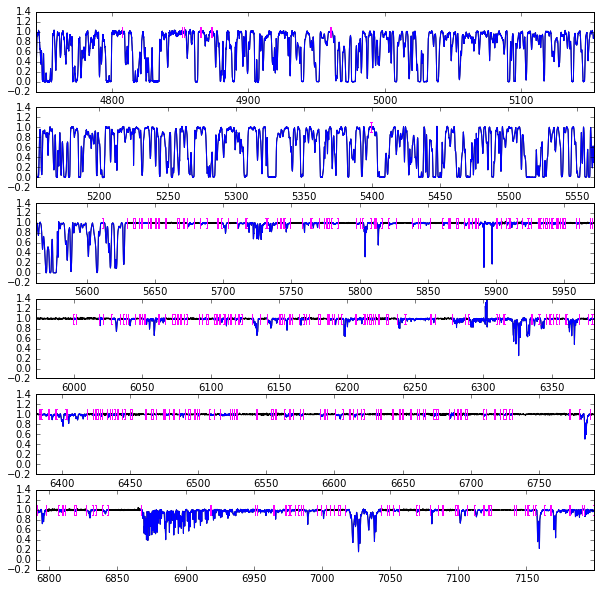

In [10]:
N = 6

fig, ax = plt.subplots(N, figsize=(10,10))

for n in range(N):
    
    length = len(cont) / N
    
    lower_lim = n*length
    upper_lim = n*length+length
    
    ax[n].plot(cont[:,0], cont[:,2], c='black')
    
    ax[n].set_xlim(cont[:,0][lower_lim], cont[:,0][upper_lim])

    for arr in region_arrays:
        ax[n].plot(arr[0], arr[1], color='blue')

    for (start, end) in region_pixels:
        plot_bracket(cont[:,0][start], ax[n], 'left')
        plot_bracket(cont[:,0][end], ax[n], 'right')


plt.show()

## Fit

 [-----------------100%-----------------] 10000 of 10000 complete in 3.4 sec
Took: 0:00:03.355050  to finish.
n:  1
 [-----------------100%-----------------] 10000 of 10000 complete in 6.2 sec
Took: 0:00:06.188083  to finish.
1566.25850272
1026.08268595
1.52644472436


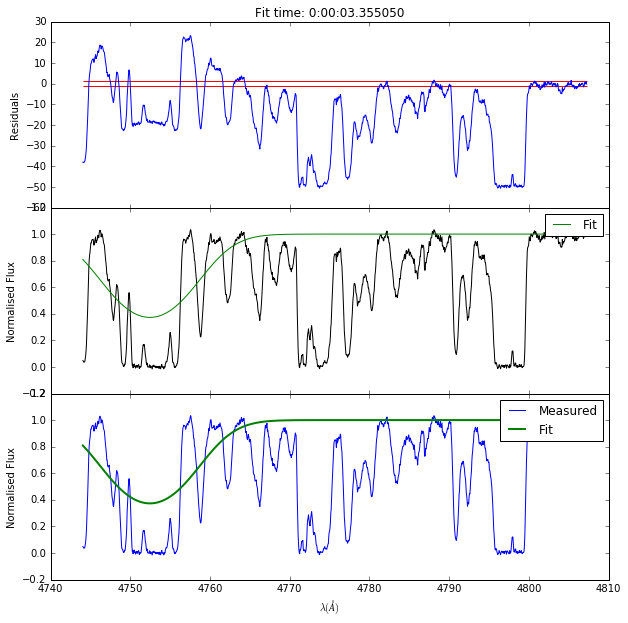

 [-----------------100%-----------------] 10000 of 10000 complete in 3.9 sec
Took: 0:00:03.852873  to finish.
n:  1
 [-----------------100%-----------------] 10000 of 10000 complete in 6.6 sec
Took: 0:00:06.574807  to finish.
774.986582533
203.570410848
3.80697066584


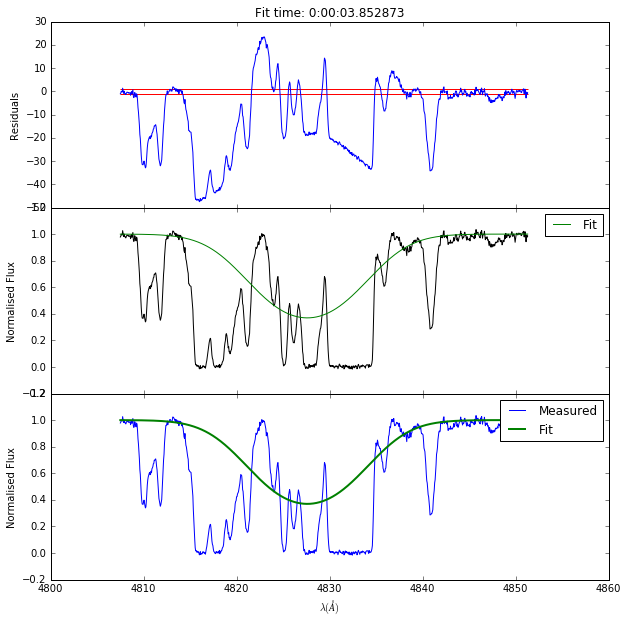

 [-----------------100%-----------------] 10000 of 10000 complete in 3.2 sec
Took: 0:00:03.167517  to finish.
n:  1
 [-----------------100%-----------------] 10000 of 10000 complete in 3.8 sec
Took: 0:00:03.832162  to finish.
10.0128329611
-106.915061408
-0.0936522210174
n:  2
 [-----------------100%-----------------] 10000 of 10000 complete in 5.6 sec
Took: 0:00:05.611987  to finish.
-106.915061408
-266.405112052
0.401325111912
n:  3
 [-----------------100%-----------------] 10000 of 10000 complete in 7.3 sec
Took: 0:00:07.311267  to finish.
-266.405112052
-369.817698684
0.720368746546
n:  4
 [-----------------100%-----------------] 10000 of 10000 complete in 11.1 sec
Took: 0:00:11.097325  to finish.
-369.817698684
-455.212810495
0.812406176096
n:  5
 [-----------------100%-----------------] 10000 of 10000 complete in 14.1 sec
Took: 0:00:14.056803  to finish.
-455.212810495
-571.283828596
0.796824253915
n:  6
 [-----------------100%-----------------] 10000 of 10000 complete in 13.9 se

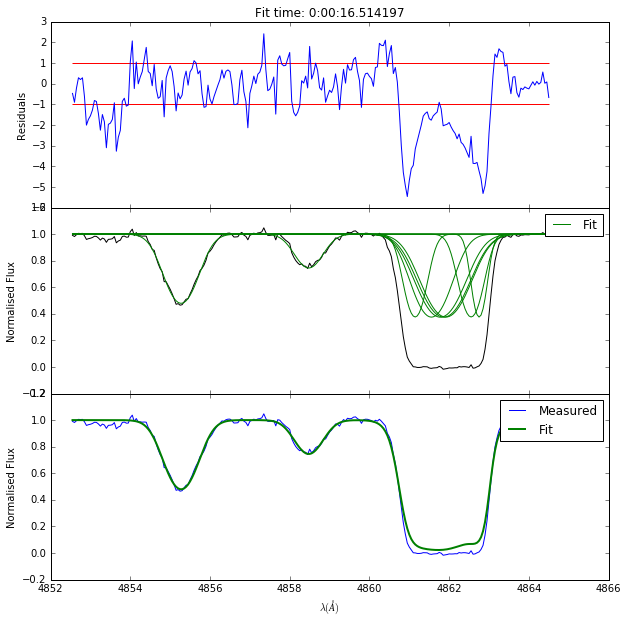

 [-----------------100%-----------------] 10000 of 10000 complete in 2.0 sec
Took: 0:00:02.000643  to finish.
n:  1
 [-----------------100%-----------------] 10000 of 10000 complete in 3.6 sec
Took: 0:00:03.633657  to finish.
-458.581639523
-767.206470501
0.597729108337
n:  2
 [-----------------100%-----------------] 10000 of 10000 complete in 4.7 sec
Took: 0:00:04.697470  to finish.
-767.206470501
-1126.47752559
0.681066823859
n:  3
 [-----------------100%-----------------] 10000 of 10000 complete in 7.0 sec
Took: 0:00:06.991996  to finish.
-1126.47752559
-905.695000664
1.24377138525


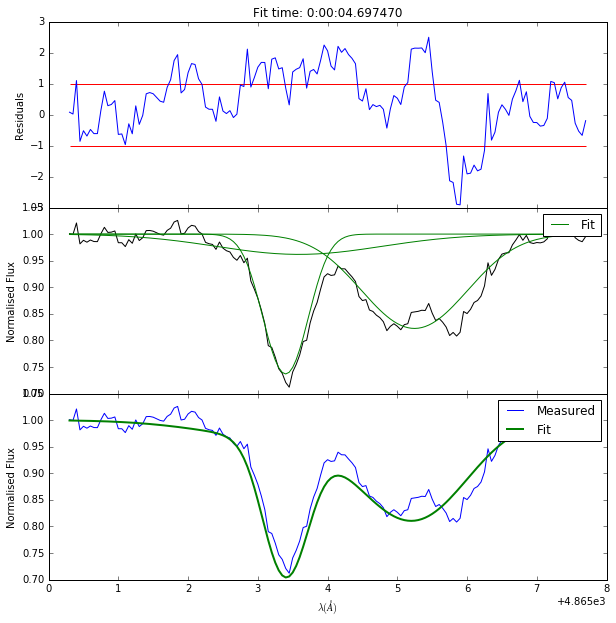

 [-----------------100%-----------------] 10000 of 10000 complete in 4.1 sec
Took: 0:00:04.082069  to finish.
n:  1
 [-----------------100%-----------------] 10000 of 10000 complete in 6.8 sec
Took: 0:00:06.823069  to finish.
1912.51594641
1541.28673478
1.24085668374


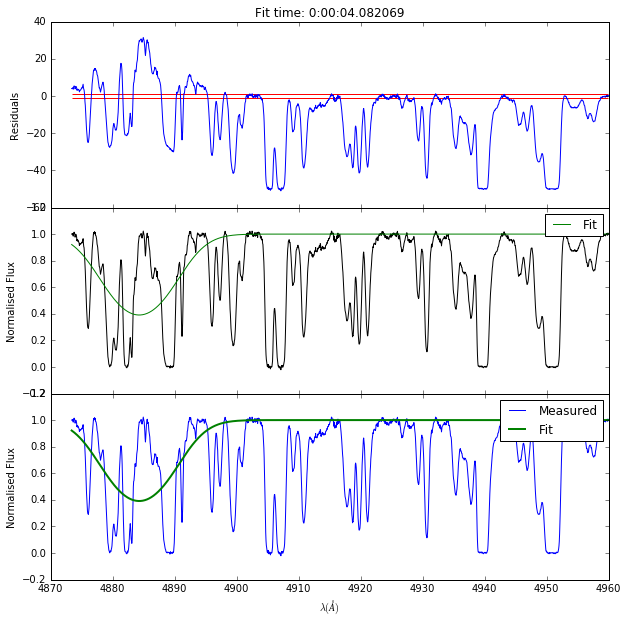

 [-----------------100%-----------------] 10000 of 10000 complete in 15.0 sec
Took: 0:00:15.026252  to finish.
n:  1
 [-----------------100%-----------------] 10000 of 10000 complete in 27.0 sec
Took: 0:00:27.027901  to finish.
10957.6400732
10365.6923539
1.05710643333


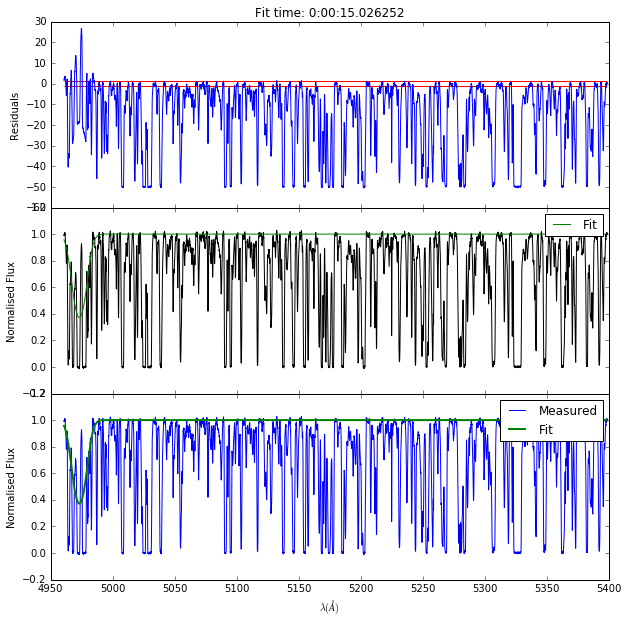

 [-----------------100%-----------------] 10000 of 10000 complete in 9.5 sec
Took: 0:00:09.485706  to finish.
n:  1
 [-----------------90%--------------    ] 9070 of 10000 complete in 13.5 secHalting at iteration  9344  of  10000

Took: 0:00:14.022762  to finish.
6814.73722787
6242.44092347
1.09167828922


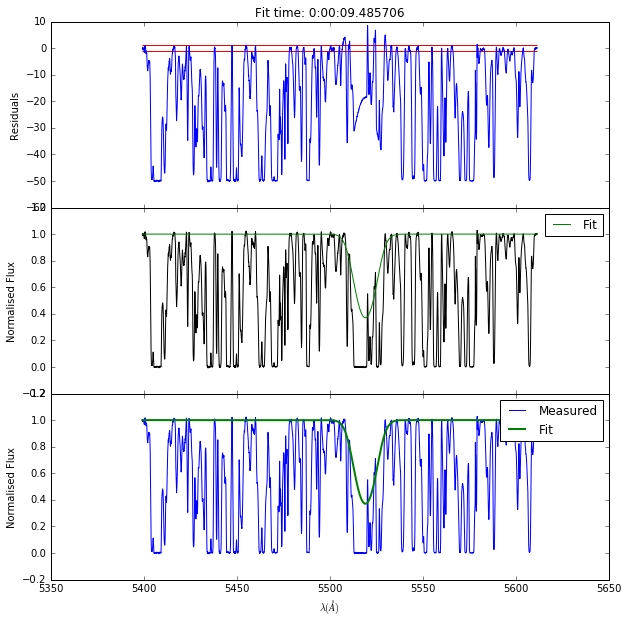

 [-----------------100%-----------------] 10000 of 10000 complete in 3.3 sec
Took: 0:00:03.305245  to finish.
n:  1
 [-----------------100%-----------------] 10000 of 10000 complete in 4.4 sec
Took: 0:00:04.376509  to finish.
142.236062746
-5.02071019261
-28.3298691399
n:  2
 [------------     33%                  ] 3308 of 10000 complete in 1.5 secHalting at iteration  4081  of  10000

Took: 0:00:01.929072  to finish.
-5.02071019261
nan
nan


/home/chris/anaconda/envs/cosmo/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/chris/anaconda/envs/cosmo/lib/python2.7/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


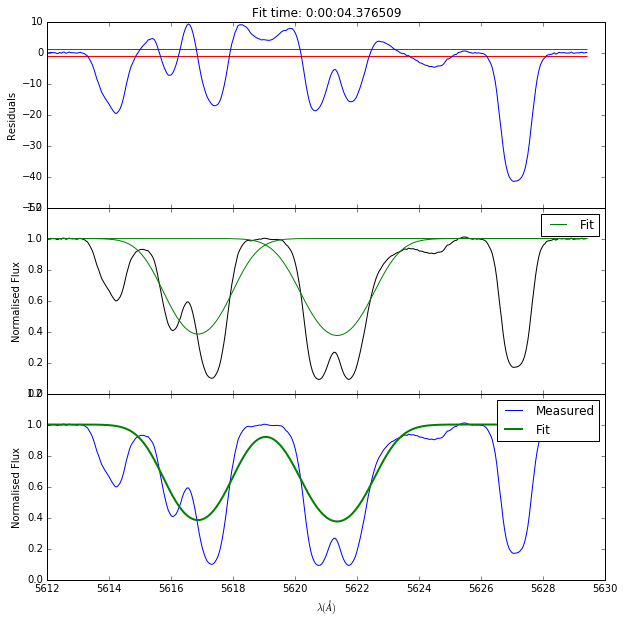

 [-----------------100%-----------------] 10000 of 10000 complete in 2.0 sec
Took: 0:00:02.016895  to finish.
n:  1
 [-----------------100%-----------------] 10000 of 10000 complete in 2.9 sec
Took: 0:00:02.852576  to finish.
-204.561059444
-346.059777198
0.59111480999
n:  2
 [-----------------100%-----------------] 10000 of 10000 complete in 5.1 sec
Took: 0:00:05.054511  to finish.
-346.059777198
-10153.3415711
0.0340833384532
n:  3
 [-----------------58%--                ] 5854 of 10000 complete in 3.0 secHalting at iteration  6692  of  10000

Took: 0:00:03.440529  to finish.
-10153.3415711
-545.143243825
18.6250892515


KeyboardInterrupt: 

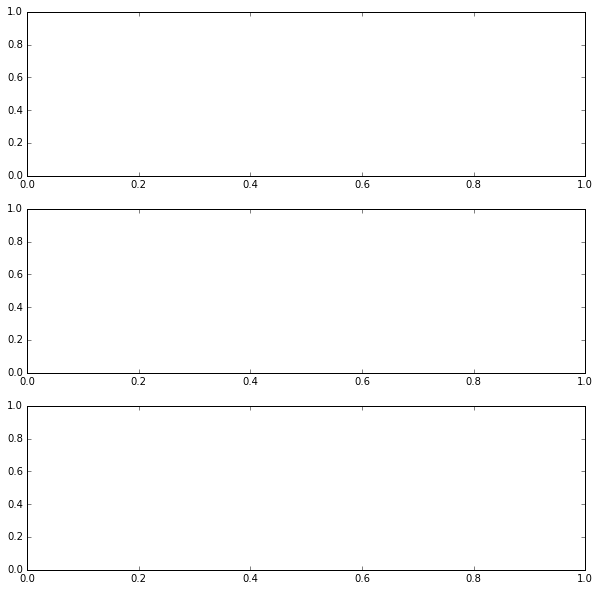

In [11]:
fits = []

for i in range(len(region_arrays)):
    wavelengths = region_arrays[i][0]
    fluxes = region_arrays[i][1]
    
    r = 0
    n = 1
    
    vpfit_2 = vpfits.VPfit()
    vpfit_2.fit(wavelengths, fluxes, n)

    while r < 0.95:

        print "n: ", n

        vpfit_1 = vpfit_2

        vpfit_2 = vpfits.VPfit()
        vpfit_2.fit(wavelengths, fluxes, n+1)

        print vpfit_1.mcmc.BPIC
        print vpfit_2.mcmc.BPIC

        print vpfit_1.mcmc.BPIC / vpfit_2.mcmc.BPIC

        r = vpfit_1.mcmc.BPIC / vpfit_2.mcmc.BPIC

        n += 1
    
    start = region_pixels[i][0]
    end = region_pixels[i][1]
    
    fits.append(vpfit_1)

    vpfit_1.plot(wavelengths, fluxes, n=n-1, start_pix=start, end_pix=end)